# 05 - Evaluation Metrics & Visualization

This notebook evaluates the performance of the Resume Matcher pipeline. It covers:
1. **Embedding Visualization**: Visualizing the distribution of job embeddings using dimensionality reduction (PCA/t-SNE).
2. **Similarity Distribution**: Analyzing the distribution of similarity scores between a sample resume and the job market.
3. **Top-K Analysis**: Retrieving top matches and inspecting their relevance.
4. **Latency Analysis**: Measuring the time taken for embedding and retrieval.

In [ ]:
!pip install seaborn wordcloud

In [ ]:
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

import json
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.features.embedding_generator import EmbeddingGenerator
from src.recommender.recommender import JobPosting, ResumeRecommender

# Setup plotting style
sns.set_theme(style="whitegrid")
%matplotlib inline

d:\OneDrive - Lambton College\Documents\1.Lambton College\semester-3\Capstone\Resume-Matcher\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-06 13:09:58,134 | INFO | faiss.loader | Loading faiss with AVX2 support.
2025-12-06 13:10:01,890 | INFO | faiss.loader | Successfully loaded faiss with AVX2 support.


## 1. Load Data
We load the processed job descriptions from the Adzuna dataset.

In [ ]:
DATA_PATH = "../data/processed/adzuna_data_jobs.json"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    jobs_data = json.load(f)

print(f"Loaded {len(jobs_data)} job postings.")

# Convert to JobPosting objects
job_postings = []
for job in jobs_data:
    # Handle varying schema if necessary
    job_postings.append(
        JobPosting(
            job_id=str(job.get("id", "")) or str(job.get("adref", "")),
            title=job.get("title", "Unknown"),
            description=job.get("description", "") or job.get("content", ""),
            company=job.get("company", {}).get("display_name", "Unknown") if isinstance(job.get("company"), dict) else job.get("company", "Unknown"),
            location=job.get("location", {}).get("display_name", "Unknown") if isinstance(job.get("location"), dict) else job.get("location", "Unknown"),
        )
    )

# Quick check
print(f"First job: {job_postings[0].title} at {job_postings[0].company}")


Loaded 500 job postings.
First job: Unknown at Xplore Inc.


## 2. Generate Embeddings
We use the `EmbeddingGenerator` to create vector embeddings for all job descriptions. We'll measure the time taken.

In [ ]:
# Initialize generator (prefer SBERT if available, fallback to TF-IDF)
generator = EmbeddingGenerator(prefer_tfidf=False)

start_time = time.time()

# Extract descriptions
descriptions = [job.description for job in job_postings]
descriptions = [d if d else " " for d in descriptions] # Handle empty descriptions

# Fit/Encode
if generator._model is None: # If using TF-IDF
    print("Training TF-IDF...")
    generator.fit_corpus(descriptions)

print("Generating embeddings...")
job_embeddings = generator.encode(descriptions)

end_time = time.time()
print(f"Embedding generation took {end_time - start_time:.2f} seconds.")
print(f"Embedding shape: {job_embeddings.shape}")

2025-12-06 13:25:05,348 | INFO | sentence_transformers.SentenceTransformer | Use pytorch device_name: cpu
2025-12-06 13:25:05,348 | INFO | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-12-06 13:25:07,738 | INFO | src.features.embedding_generator | Loaded SentenceTransformer model all-MiniLM-L6-v2


Generating embeddings...


Batches: 100%|██████████| 16/16 [00:00<00:00, 55.08it/s]

Embedding generation took 0.30 seconds.
Embedding shape: (500, 384)


## 3. Visualization of Embedding Space
We project the high-dimensional embeddings into 2D using PCA and t-SNE, and color them by Clusters.

d:\OneDrive - Lambton College\Documents\1.Lambton College\semester-3\Capstone\Resume-Matcher\env\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Running t-SNE...


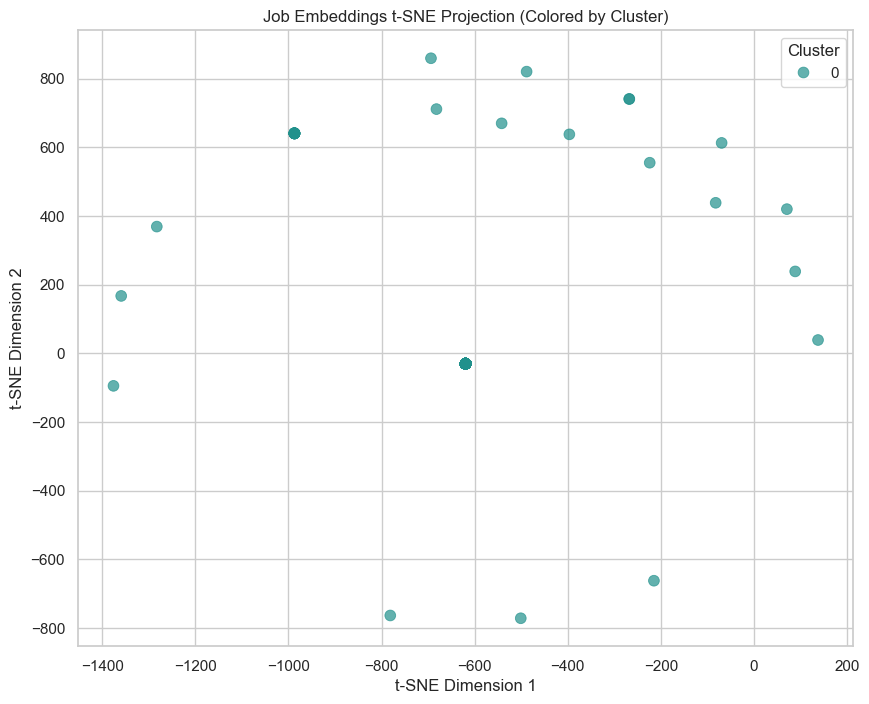

In [ ]:
# 1. Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(job_embeddings)

# 2. t-SNE for better 2D projection
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vis_dims_tsne = tsne.fit_transform(job_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=vis_dims_tsne[:,0], 
    y=vis_dims_tsne[:,1], 
    hue=cluster_labels, 
    palette="viridis",
    s=60,
    alpha=0.7, 
    edgecolor=None
)
plt.title("Job Embeddings t-SNE Projection (Colored by Cluster)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()

## 4. Matching Analysis
We create a sample resume and calculate similarity scores against all jobs. We also project the resume into the job market space.

In [ ]:

# 5 Simulated Resumes for Evaluation
sample_resumes = [
    # 1. Data Scientist (User Provided)
    """
    Data scientists with 2.5+ years of combined experience and a strong foundation in Statistics, data modeling, Analytics,
    Building ETL Pipelines, Python development, Machine Learning, API Integration. Skilled in Python, SQL, Power BI, and
    EDA with expertise in predictive modeling, data storytelling, and visualization. Certified in Google Advanced Data
    Analytics and Azure AI, delivering impactful, data-driven insights and solutions.
    EDUCATION
    Lambton College - Ottawa, Canada Sep 2024 – Apr 2026
    Postgraduate Diploma in Machine Learning and AI (Data Specialized) - GPA: 3.75/4.0
    """, 
    
    # 2. Senior Software Engineer
    """
    Senior Software Engineer with 8 years of experience designing and building scalable backend systems.
    Expert in Python, Django, and Go. Proficient in microservices architecture, RESTful API design, and database optimization (PostgreSQL, Redis).
    Deep understanding of cloud infrastructure (AWS: EC2, Lambda, S3, RDS). Proven leader in agile teams, mentoring junior developers and driving code quality.
    Experience with CI/CD pipelines (Jenkins, GitHub Actions).
    """,

    # 3. Frontend Developer
    """
    Creative Frontend Developer with 4 years of experience building responsive and interactive web applications.
    Specialized in React.js ecosystem (Redux, React Hooks, Next.js). Strong proficiency in JavaScript (ES6+), TypeScript, HTML5, and CSS3 (Sass, Tailwind).
    Focused on user experience (UX) and accessibility (WCAG). Experience integrating REST and GraphQL APIs.
    Portfolio includes e-commerce platforms and dashboard analytics tools.
    """,

    # 4. DevOps Engineer
    """
    DevOps Engineer with a focus on automation and infrastructure as code.
    Skilled in deploying and managing containerized applications using Docker and Kubernetes.
    Extensive experience with Terraform and Ansible for configuration management.
    Proficient in setting up monitoring and logging solutions (Prometheus, Grafana, ELK Stack).
    Strong background in Linux system administration and scripting (Bash, Python). Certified AWS Solutions Architect.
    """,

    # 5. Product Manager
    """
    Product Manager with 6 years of experience leading cross-functional teams to deliver B2B SaaS products.
    Skilled in product discovery, roadmap planning, and requirement definition (User Stories, PRDs).
    Strong analytical skills, using tools like Amplitude and Mixpanel to drive data-informed decisions.
    Excellent stakeholder management and communication skills. Certified Scrum Product Owner (CSPO).
    Experience in fintech and enterprise software sectors.
    """
]

print(f"Defined {len(sample_resumes)} sample resumes.")


Defined 5 sample resumes.


In [ ]:

# Generate embeddings for the 5 resumes
print("Generating resume embeddings...")
resume_embeddings = generator.encode(sample_resumes)

# Compute similarities for all resumes
all_scores = cosine_similarity(resume_embeddings, job_embeddings)

# --- Visualization 1: Similarity Distributions ---
plt.figure(figsize=(15, 10))
titles = ["Data Scientist", "Senior Software Engineer", "Frontend Developer", "DevOps Engineer", "Product Manager"]

for i, scores in enumerate(all_scores):
    plt.subplot(2, 3, i+1)
    sns.histplot(scores, bins=30, kde=True)
    plt.title(f"Similarity: {titles[i]}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# --- Visualization 2: PCA Projection ---
# Re-fit PCA on jobs + resumes or just jobs? fitting on jobs is standard.
pca = PCA(n_components=2)
job_pca = pca.fit_transform(job_embeddings)
# Transform resumes into the same space
resumes_pca = pca.transform(resume_embeddings)

plt.figure(figsize=(12, 10))

# 1. Plot Jobs (Background) - colored by cluster if cluster_labels exists
if 'cluster_labels' in locals():
    sns.scatterplot(
        x=job_pca[:,0], 
        y=job_pca[:,1], 
        hue=cluster_labels, 
        palette="viridis",
        alpha=0.3,
        legend='full'
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Job Clusters")
else:
    sns.scatterplot(x=job_pca[:,0], y=job_pca[:,1], alpha=0.3)

# 2. Plot Resumes (Big Stars)
colors = ['red', 'blue', 'orange', 'black', 'purple']
shapes = ['*', 's', '^', 'D', 'P'] # Star, Square, Triangle, Diamond, Plus

for i in range(len(sample_resumes)):
    plt.scatter(
        resumes_pca[i,0], 
        resumes_pca[i,1], 
        c=colors[i], 
        marker=shapes[i], 
        s=300, 
        edgecolor='white',
        label=f"Resume: {titles[i]}"
    )

plt.title("5 Sample Resumes in the Job Market (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
if 'cluster_labels' not in locals():
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Top-K Recommendations

In [ ]:
top_k = 5
titles = ["Data Scientist", "Senior Software Engineer", "Frontend Developer", "DevOps Engineer", "Product Manager"]

for i, scores in enumerate(all_scores):
    print(f"\n--- Top Matches for {titles[i]} ---")
    top_indices = np.argsort(scores)[::-1][:top_k]
    for idx in top_indices:
        job = job_postings[idx]
        title = job.title or "Unknown"
        company = job.company or "Unknown"
        print(f"[{scores[idx]:.4f}] {title} at {company}")


NameError: name 'all_scores' is not defined

In [ ]:

# Matching Analysis Visualization
import pandas as pd

# Prepare data for plotting
match_data = []
top_k = 5

# Assuming 'all_scores' and 'titles' are available from previous cells
for i, scores in enumerate(all_scores):
    top_indices = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_indices]
    
    for rank, score in enumerate(top_scores):
        match_data.append({
            "Resume": titles[i],
            "Rank": f"Rank {rank+1}",
            "Similarity Score": score
        })

df_matches = pd.DataFrame(match_data)

# 1. Grouped Bar Chart: Top 5 Match Scores
plt.figure(figsize=(14, 7))
sns.barplot(data=df_matches, x="Resume", y="Similarity Score", hue="Rank", palette="viridis")
plt.title("Top 5 Job Match Similarity Scores by Resume Profile", fontsize=16)
plt.xlabel("Resume Profile", fontsize=12)
plt.ylabel("Cosine Similarity Score", fontsize=12)
plt.legend(title="Match Rank", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. Summary Chart: Average Match Quality
plt.figure(figsize=(12, 6))
avg_scores = df_matches.groupby("Resume")["Similarity Score"].mean().sort_values(ascending=False)
bars = sns.barplot(x=avg_scores.index, y=avg_scores.values, palette="magma")
plt.title("Average Similarity of Top 5 Recommendations", fontsize=16)
plt.ylabel("Average Cosine Similarity", fontsize=12)
plt.xlabel("Resume Profile", fontsize=12)
plt.xticks(rotation=15)

# Add value labels
for i, v in enumerate(avg_scores.values):
    bars.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:

# Matching Analysis Visualization
import pandas as pd

# Prepare data for plotting
match_data = []
top_k = 5

# Assuming 'all_scores' and 'titles' are available from previous cells
for i, scores in enumerate(all_scores):
    top_indices = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_indices]
    
    for rank, score in enumerate(top_scores):
        match_data.append({
            "Resume": titles[i],
            "Rank": f"Rank {rank+1}",
            "Similarity Score": score
        })

df_matches = pd.DataFrame(match_data)

# 1. Grouped Bar Chart: Top 5 Match Scores
plt.figure(figsize=(14, 7))
sns.barplot(data=df_matches, x="Resume", y="Similarity Score", hue="Rank", palette="viridis")
plt.title("Top 5 Job Match Similarity Scores by Resume Profile", fontsize=16)
plt.xlabel("Resume Profile", fontsize=12)
plt.ylabel("Cosine Similarity Score", fontsize=12)
plt.legend(title="Match Rank", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. Summary Chart: Average Match Quality
plt.figure(figsize=(12, 6))
avg_scores = df_matches.groupby("Resume")["Similarity Score"].mean().sort_values(ascending=False)
bars = sns.barplot(x=avg_scores.index, y=avg_scores.values, palette="magma")
plt.title("Average Similarity of Top 5 Recommendations", fontsize=16)
plt.ylabel("Average Cosine Similarity", fontsize=12)
plt.xlabel("Resume Profile", fontsize=12)
plt.xticks(rotation=15)

# Add value labels
for i, v in enumerate(avg_scores.values):
    bars.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
